In [1]:
import matplotlib.pyplot as plt
import albumentations as A

from detection.default_boxes.default_boxes import DefaultBoxHandler
from detection.dataset.dataset_generator import DataGenerator, Dataset
from detection.utils.box_tools import draw_box
%load_ext autoreload

In [2]:
image_path = "/home/t9s9/PycharmProjects/BeeMeter/data/training/base_training_img"
labels_path = "/home/t9s9/PycharmProjects/BeeMeter/data/training/base_labels.db"
ds = Dataset.from_sqlite(image_path, labels_path, verbose=True, limit=10)
ds.load_images_in_memory(verbose=True)

Loading images into memory: 100%|██████████| 10/10 [00:00<00:00, 96.34it/s]


/home/t9s9/PycharmProjects/BeeMeter/detection/dataset/dataset_album.py:188: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return cls(np.array(filenames), np.array(image_ids), np.array(labels), nr_labels=nr_labels,


In [3]:
width, height = 420, 240
# min_area: minimum area of a bounding box. All bounding boxes whose visible area in pixels is less than this value will be removed
# min_visibility: minimum fraction of area for a bounding box to remain this box in list
bbox_params = A.BboxParams(format='pascal_voc', min_area=0, min_visibility=0.1, label_fields=['box_class'])
transform_soft = A.Compose([
            A.Resize(width=width, height=height, p=1, always_apply=True),
            A.OneOf([
                A.Sequential([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.2, p=0.75),
                    A.RandomSizedCrop(width=width, height=height, min_max_height=(height//2, height//1.5), w2h_ratio=width/height, p=0.2)
                ]),
                A.Sequential([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.1, hue=0.1, p=0.75),
                    A.RandomSizedCrop(width=width, height=height, min_max_height=(height//2, height//1.5), w2h_ratio=width/height, p=0.2)
                ])
            ], p=0.9)
        ], bbox_params)

In [7]:
box_handler = DefaultBoxHandler(image_size=(width, height), feature_map_sizes=[(30,20),(20,10),(10,5)], scale_min=0.1,
                                scale_max=0.9, aspect_ratios_global=[1/3, 1, 3/2], standardizing=None)
gen = DataGenerator(ds, encoder=box_handler, batch_size=10, shuffle=True, transformation=transform_soft, std=True)
print(box_handler.num_boxes)

Creating default boxes for every feature layer: 100%|██████████| 3/3 [00:00<00:00, 3594.09it/s]


BOX STD: [1.0, 1.0, 1.0, 1.0]
MEAN [10.759723432577152, 8.676025828915813, 11.195028849913015, 9.273959207996405]
FITTED: [16.895706229471912, 11.421692828663689, 17.299445108209817, 11.957168269934035]
2550


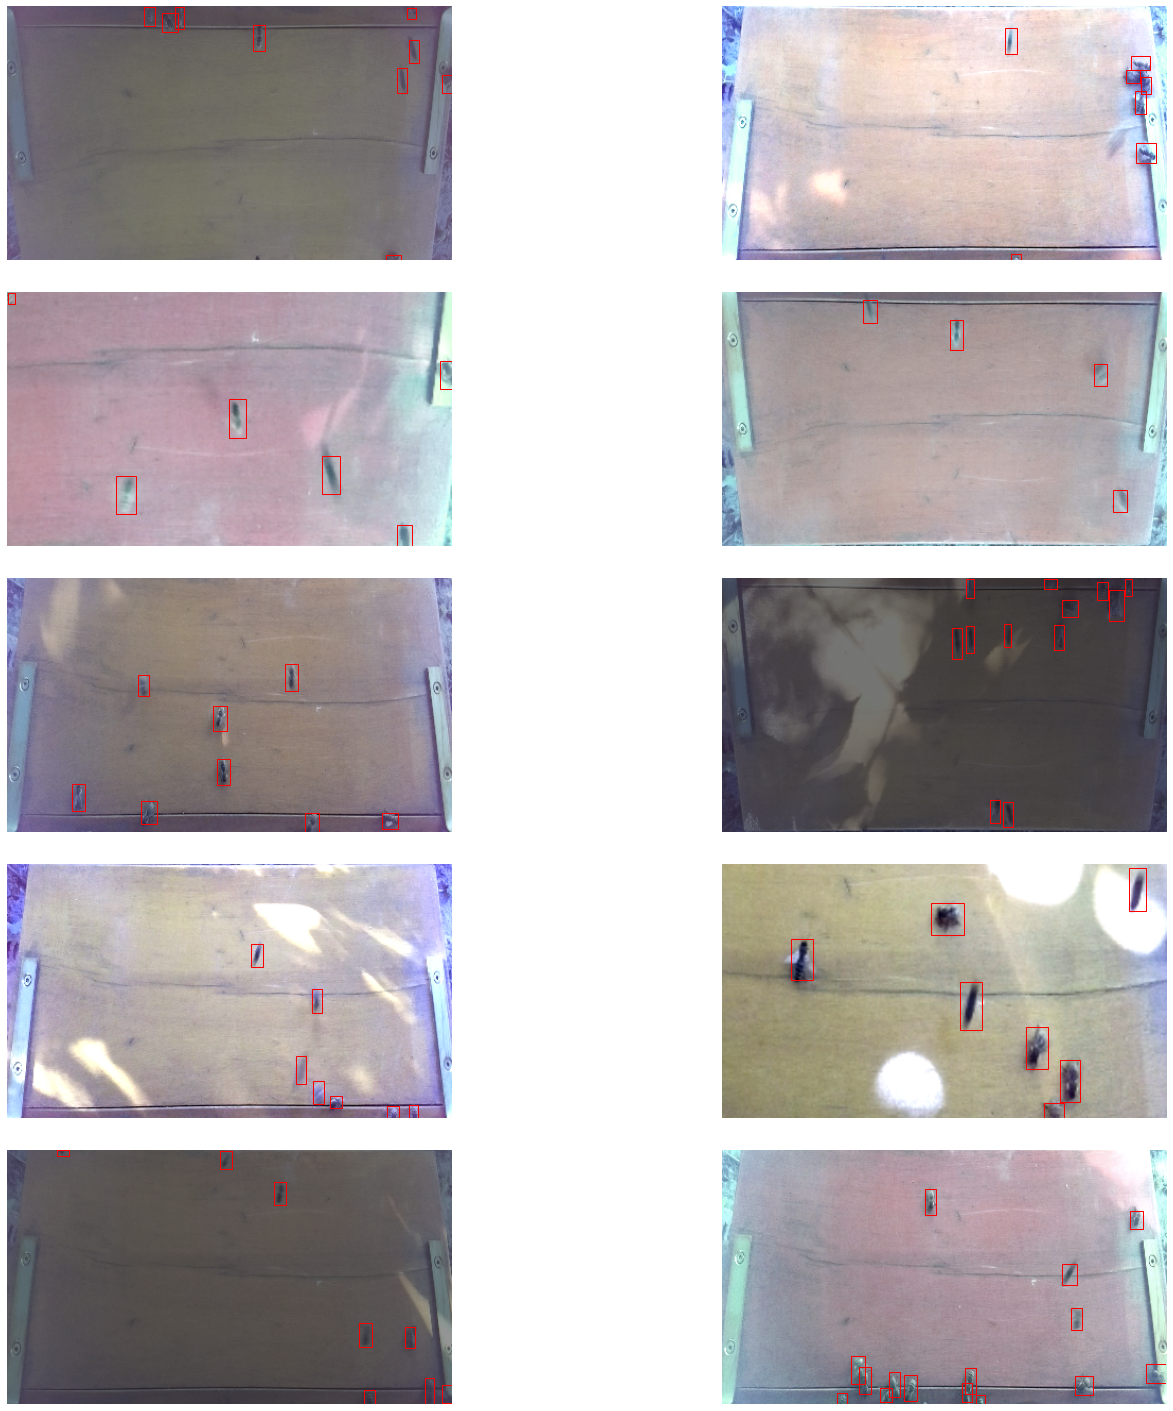

In [8]:
batch_x, batch_y = gen[0]
decoded_boxes = box_handler.faster_decode_default_boxes(batch_y.astype('float32'), no_score=True)
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
plt.tight_layout()
ax = ax.flatten()
for i in range(10):
    draw_box(batch_x[i], boxes=decoded_boxes[i], engine='plt', axis=ax[i])